In [1]:
import pandas as pd
import datasets
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import sklearn

from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn import FunctionSampler  # to use a idendity sampler

from pandas.api.types import CategoricalDtype

In [2]:
np.random.seed(0)
IMPUTATION_REQUIRED=0
TRAIN_SIZE=0.8
PAR_NORMALIZE=0
PAR_SCALE=1
target_col = 'lrgen' # 'lrgen', 'lrecon', 'galtan'
target_factor = target_col + '_factor' # 'lrgen_factor', 'lrecon_factor', 'galtan_factor'
# check if data is imputed or not
IMPUTED_DATA = 'No' # 'Yes' if imputed
SOURCE_DATA_FILES = 'data/base_data/recategorized_4l3c4r/' #'data/imputed_data/recategorized/imputation_cart/'
FILE_SUFFIX = '_recategorized'

In [3]:
#data_raw = pd.read_csv("data/CHES2019_experts_imputed_cart.csv", index_col=0).reset_index(drop=True)
data_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_train' + FILE_SUFFIX + '.csv', index_col = 0)
data_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_train' + FILE_SUFFIX + '.csv', index_col = 0)
if IMPUTED_DATA == 'Yes':
    valid_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_valid' + FILE_SUFFIX + '.csv', index_col = 0)
    valid_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_valid' + FILE_SUFFIX + '.csv', index_col = 0)
test_X = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_X_test' + FILE_SUFFIX + '.csv', index_col = 0)
test_y = pd.read_csv(SOURCE_DATA_FILES + 'data_' + target_col + '_base_y_test' + FILE_SUFFIX + '.csv', index_col = 0)
#data = pd.read_csv("data/CHES2019_experts_imputed_pmm.csv")

# Data preprocessing
Preprocessing steps (after imputation in R)

In [4]:
# split data into training and test dataset
# split data for obtaining a separated TEST dataset (not used for training)
X_train = data_X
X_test = test_X
y_train = data_y
y_test = test_y

In [5]:
# standardization/normalization of data
# Be aware: information related to scaling MUST NOT flow into the separated datasets
# --> 1st split, 2nd scaling
if (PAR_NORMALIZE==1):
    data_normalized = preprocessing.normalize(X_train)

if (PAR_SCALE==1):
    scaler = preprocessing.StandardScaler().fit(X_train)
    data_scaled = scaler.transform(X_train)

In [6]:
X_train_base = X_train
y_train_base = y_train

In [7]:
X_train.describe()

,econ_interven,environment,redistribution,civlib_laworder,immigrate_policy,sociallifestyle
count,2593.000000,2593.000000,2593.000000,2593.000000,2593.000000,2593.000000
mean,4.573853,5.212495,4.440417,5.054377,5.570767,4.288855
std,2.652167,2.625398,2.539734,2.911194,2.902297,3.227883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000
50%,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000
75%,7.000000,7.000000,6.000000,7.000000,8.000000,7.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [8]:
y_train['lrgen_factor'].value_counts()

c    968
r    913
l    712
Name: lrgen_factor, dtype: int64

In [10]:
y_train

,lrgen_factor
0,c
1,r
2,c
3,r
4,c
...,...
2899,r
2900,r
2901,r
2902,r


# Oversampling to balance the dataset regarding target variable

In [9]:
#samplers = [
#    FunctionSampler(),
#    RandomOverSampler(random_state=0),
#    SMOTE(random_state=0),
#    ADASYN(random_state=0),
#]


#X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_train_base, y_train_base)


###
X_train, y_train = SMOTE(random_state=0, sampling_strategy='not majority').fit_resample(X_train_base, y_train_base)
###



#X_train, y_train = ADASYN(random_state=0, sampling_strategy='minority').fit_resample(X_train_base, y_train_base)


#for sampler in samplers:
#    sampler.fit_resample(X_train, y_train)




In [20]:
y_train.value_counts()

lrgen_factor
c               968
l               968
r               968
dtype: int64

# Principal Component Analysis: reduce dimensionality

In [21]:
# create a PCA with 2 components
# combine the result with the target result
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 
                                        'PC2'],
                          index=X_train.index)
finalDf = pd.concat([principalDf, y_train], axis = 1)


In [22]:
pca.components_

array([[ 0.24313559,  0.38402695,  0.27737627,  0.47569983,  0.48092611,
         0.50881288],
       [ 0.68901945,  0.03216504,  0.59006418, -0.22539783, -0.15460797,
        -0.31833013]])

In [23]:
finalDf.tail()

,PC1,PC2,lrgen_factor
2899,-0.942086,1.561020,r
2900,0.248110,2.187137,r
2901,1.371681,3.154803,r
2902,8.207977,2.744777,r
2903,-0.833376,5.508549,r


In [24]:
finalDf[target_factor].factorize()[0]

array([0, 1, 0, ..., 1, 1, 1])

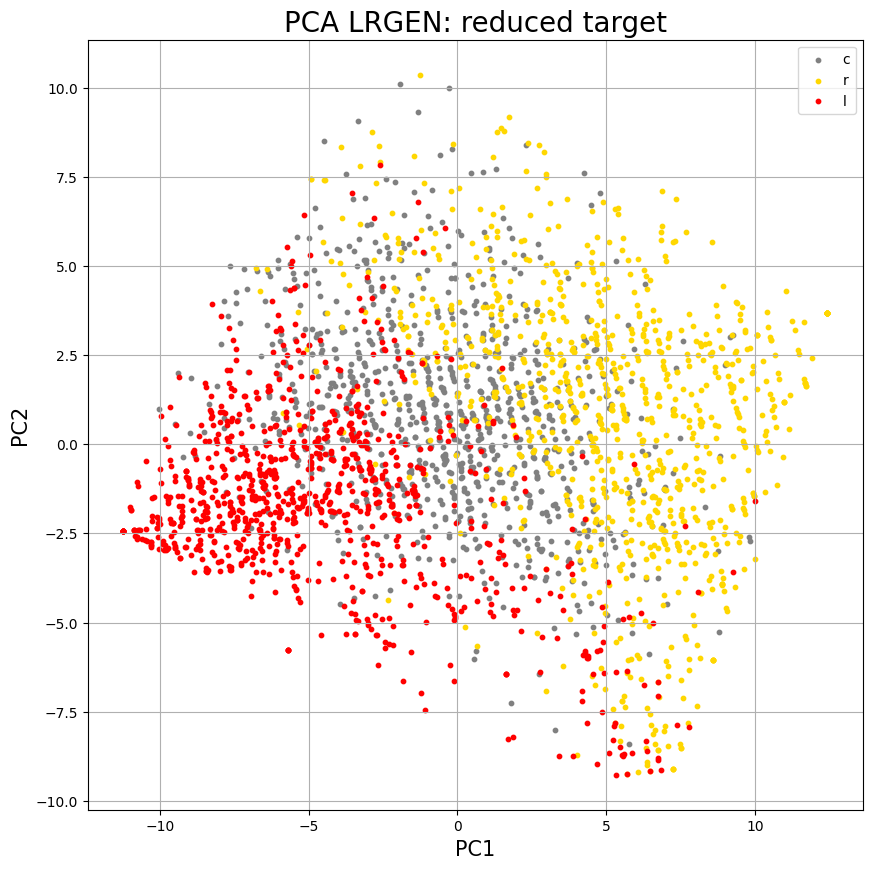

In [25]:
# visualize the results of the PCA
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA LRGEN: reduced target', fontsize = 20)

targets = range(0,3)
colors = ['grey', 'gold', 'r']#, 'c',  'm',  'y',  'k',  'gray',  'lime',  'orange',  'gold']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[target_factor].factorize()[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 10)
ax.legend(['c', 'r', 'l']) #targets)#
ax.grid()
#plt.savefig('pics/PCA_LRGEN_REDUCED_low_resolution.png', dpi=150)

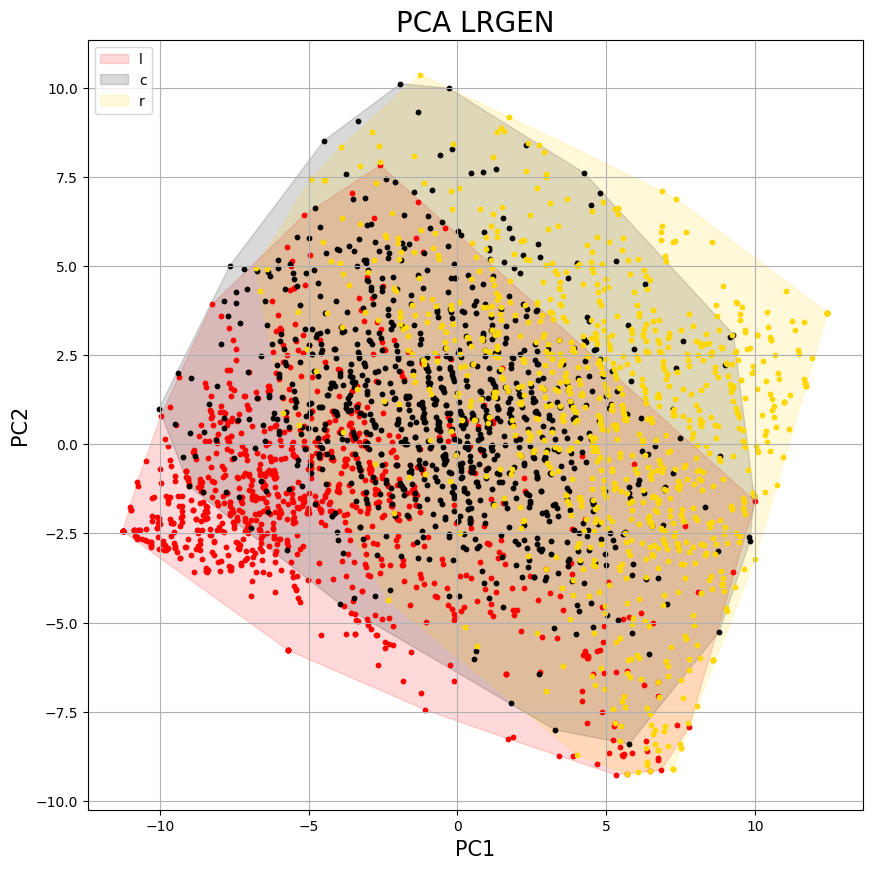

In [26]:
# visualize the results of the PCA
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA LRGEN', fontsize = 20)

targets = [2,0,1] #range(0,3)
colors = ['r', 'black', 'gold'] #['black', 'gold', 'r']
for target, color in zip(targets,colors):
    points = finalDf[finalDf[target_factor].factorize()[0] == target][['PC1', 'PC2']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    plt.fill(x_hull, y_hull, alpha=0.15, c=color)
    #ax.legend(['l', 'c', 'r'])
#ax.legend(['c', 'r', 'l'])
    
    
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[target_factor].factorize()[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 10)
    #ax.legend(['l', 'c', 'r'])

    
ax.legend(['l', 'c', 'r'],) #ax.legend(['c', 'r', 'l']) #targets)#
ax.grid()
plt.savefig('pics/PCA_LRGEN_REDUCED', dpi=300)



    

from sklearn.manifold import TSNE

tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X_train)
colordict = {
  "c": "blue",
  "r": "red",
  "l": "green"
}
y=y_train
y = y.replace({'lrgen_factor': colordict})


plt.figure(figsize=(12, 10))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y['lrgen_factor'].values,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()
plt.title("MNIST. t-SNE projection");

In [27]:
# about 80% of the variance are explained through the 2 components
pca.explained_variance_ratio_

array([0.60133406, 0.2075889 ])

# Clustering
Check if some patterns can be observed using unsupervised learning

In [ ]:
# try to obtain best number of clusters through scree plot
distortions = []
for i in range(1, 15):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=3000,
        tol=1e-04, random_state=0
    )
    km.fit(finalDf[['PC1', 'PC2']])
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
# try to cluster results of PCA
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=3000, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(finalDf[['PC1', 'PC2']])

In [ ]:
y_km

In [ ]:
cluster_data = pd.concat([finalDf, 
                          pd.DataFrame(y_km, 
                                       index=X_train.index, 
                                       columns=['cluster'])], 
                         axis=1)

In [ ]:
cluster_data.head(20)
#cluster_data[cluster_data['lrgen_factor']==10]['cluster'].value_counts()

In [ ]:
cluster_data.pivot_table(aggfunc='count', columns = [target_factor, 'cluster']).T

# Supervised learning: various algorithms
### Sources: https://vitalflux.com/grid-search-explained-python-sklearn-examples/

## 1) Support Vector Classification

CHECK: RMSE and other scoring mechanisms

In [ ]:
########### PARAMETERS 
scoring_method = 'balanced_accuracy'#['balanced_accuracy', 'f1_samples', 'roc_auc_ovo_weighted']
cv_nr = 5

In [ ]:
# CROSS-VALIDATION (without TEST dataset)

clf = SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X_train, np.ravel(y_train), cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [ ]:
pipelineSVC = make_pipeline(StandardScaler(), SVC(random_state=1))
# Create the parameter grid
param_grid_svc = [{
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['linear'],
                    'svc__degree': [1,2,3,4,5]
                  },
                 {
                    'svc__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__gamma': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
                    'svc__kernel': ['rbf']
                 }]
# Create an instance of GridSearch Cross-validation estimator
gsSVC = GridSearchCV(estimator=pipelineSVC,
                     param_grid = param_grid_svc,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the SVM classifier
gsSVC.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsSVC.best_score_)
# Print the model parameters of the best model
print(gsSVC.best_params_)
# Print the model score on the test data using GridSearchCV score method
print('Test accuracy: %.3f' % gsSVC.score(X_test, y_test))
# Print the model score on the test data using Best estimator instance
clfSVC = gsSVC.best_estimator_
#print('Test accuracy: %.3f' % clfSVC.score(X_test, y_test))

## Random Forest Classification

In [ ]:
pipelineRFC = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1, criterion='entropy')) 
# Create the parameter grid
                            
param_grid_rfc = [{
    'randomforestclassifier__max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6],
    'randomforestclassifier__n_estimators':range(5, 105, 5)#,
    #'randomforestclassifier__criterion:':['gini', 'entropy']
}]
# Create an instance of GridSearch Cross-validation estimator
gsRFC = GridSearchCV(estimator=pipelineRFC,
                     param_grid = param_grid_rfc,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the RandomForestClassifier
gsRFC = gsRFC.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsRFC.best_score_)
# Print the model parameters of the best model
print(gsRFC.best_params_)
# Print the test score of the best model
clfRFC = gsRFC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(X_test, y_test))

In [ ]:
RandomForestClassifier().get_params().keys()

## Logistic Regression Classification

In [ ]:
pipelineLR = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, penalty='l2', solver='lbfgs'))
# Create the parameter grid
param_grid_lr = [{
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
}]
# Create an instance of GridSearch Cross-validation estimator
gsLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the LogisticRegression Classifier
gsLR = gsLR.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsLR.best_score_)
# Print the model parameters of the best model
print(gsLR.best_params_)
# Print the test score of the best model
clfLR = gsLR.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(X_test, y_test))

## ADABoost Classification (Ensemble Method)

In [ ]:
pipelineADAB = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=1))
# Create the parameter grid
param_grid_ADAB = [{
    'adaboostclassifier__n_estimators': [2, 10, 20, 30, 40, 50, 100]
}]
# Create an instance of GridSearch Cross-validation estimator
gsADAB = GridSearchCV(estimator=pipelineADAB,
                     param_grid = param_grid_ADAB,
                     scoring=scoring_method,
                     cv=cv_nr,
                     refit=True,
                     n_jobs=1)
# Train the LogisticRegression Classifier
gsADAB = gsADAB.fit(X_train, np.ravel(y_train))
# Print the training score of the best model
print(gsADAB.best_score_)
# Print the model parameters of the best model
print(gsADAB.best_params_)
# Print the test score of the best model
clfADAB = gsADAB.best_estimator_
print('Test accuracy: %.3f' % clfADAB.score(X_test, y_test))

In [ ]:
gsADAB.scoring

# Test models with independent dataset

In [ ]:
#scaler = preprocessing.StandardScaler().fit(test_X)
#test_X_scaled = scaler.transform(test_X)

In [ ]:
sklearn.metrics.accuracy_score(test_y, gsADAB.predict(test_X))

In [ ]:
sklearn.metrics.confusion_matrix(test_y, gsADAB.predict(test_X))

In [ ]:
#sklearn.metrics.mean_squared_error(test_y, gsADAB.predict(test_X))

In [ ]:
sklearn.metrics.f1_score(test_y, gsADAB.predict(test_X), average='weighted')

In [ ]:
sklearn.metrics.accuracy_score(test_y, gsLR.predict(test_X))

In [ ]:
sklearn.metrics.confusion_matrix(test_y, gsLR.predict(test_X))

In [ ]:
#sklearn.metrics.mean_squared_error(test_y, gsLR.predict(test_X))

In [ ]:
sklearn.metrics.f1_score(test_y, gsLR.predict(test_X), average='weighted')

In [ ]:
sklearn.metrics.accuracy_score(test_y, gsRFC.predict(test_X))

In [ ]:
sklearn.metrics.confusion_matrix(test_y, gsRFC.predict(test_X))

In [ ]:
#sklearn.metrics.mean_squared_error(test_y, gsRFC.predict(test_X))

In [ ]:
sklearn.metrics.f1_score(test_y, gsRFC.predict(test_X), average='weighted')

In [ ]:
sklearn.metrics.accuracy_score(test_y, gsSVC.predict(test_X))

In [ ]:
sklearn.metrics.confusion_matrix(test_y, gsSVC.predict(test_X))

In [ ]:
#sklearn.metrics.mean_squared_error(test_y, gsSVC.predict(test_X))

In [ ]:
sklearn.metrics.f1_score(test_y, gsSVC.predict(test_X), average='weighted')

In [ ]:
#pipeline = Pipeline(steps=[("preprocesser", preprocessor), ("classifier", LogisticRegression())])
#pipeline.fit(X_train, y_train)

In [ ]:
#pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

In [ ]:
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
#pipe.fit(X_train, y_train)
#Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])
#pipe.score(X_test, y_test)

In [ ]:
### Write several scores to the output ###

RMSE = False
model_vector = [gsADAB, gsLR, gsRFC, gsSVC]
for model in model_vector:
    print(model.estimator.named_steps)
    print('Accuracy Score: ', sklearn.metrics.accuracy_score(test_y, model.predict(test_X)))
    print('Balanced Accuracy Score: ', sklearn.metrics.balanced_accuracy_score(test_y, model.predict(test_X)))
    print('Cohen-Kappa-Score: ', sklearn.metrics.cohen_kappa_score(test_y, model.predict(test_X)))
    print('F1-Score: ', sklearn.metrics.f1_score(test_y, model.predict(test_X), average='weighted'))
    if RMSE == True:
        print('RMSE: ', sklearn.metrics.mean_squared_error(test_y, model.predict(test_X)))
        #print('ROC-AUC-Score: ', sklearn.metrics.roc_auc_score(test_y, 
        #                                                       model.predict(test_X), 
        #                                                       average='weighted', 
        #                                                       multi_class='ovo'))
    print('__________________________________\n')

for model in model_vector:
    print('Confusion matrix: \n', sklearn.metrics.confusion_matrix(test_y, model.predict(test_X)))

for model in model_vector:
    print(sklearn.metrics.classification_report(test_y, model.predict(test_X)))

In [ ]:
print('Features:           ', gsRFC.feature_names_in_)
print('Feature Importance: ', gsRFC.best_estimator_[1].feature_importances_)

In [ ]:
from joblib import dump, load
dump(gsRFC, 'models/gsRFC_lrgen_reducedtarget_4l3c4r_NoImputation.joblib') 
#clf = load('filename.joblib')
